# The Premise

Well, most of the problems that we tried to tackle, and the models that we built.

Turns out there are already people that have spent the time crafting a better model than us<br>
And these problems have already been solved, and optimized with state-of-the-art models (the best performing model at those tasks)


- Image Classification? There's a Model!
- Speech Recognition? There's a Model!
- TTS? There's a Mpdel!
- Facial Recognition? There's a Model!
- Self-Driving Cars? There's a Model!
- NLP? There's a Model!
- And the list goes on and on



Transfer learning allows us to leverage the knowledge gained from one problem and apply it to a different, but related, problem.

Like there are existing image classification models, but we want to build a model that specifically only classifies images of food, so we can use transfer learning, and specialize, train further from the existing networks.

## Natural Language Processing Example

Nowadays, anyone can built their own tailored GPT for specific tasks on the GPT store.

They are are based from ChatGPT, the fundamental model, but specialized with additional training data in specific fields.

Like look here, someone made a Image Generation GPT, a company made a Research Paper GPT, there's a Novel Writing GPT...

<img src="assets/GPT Models.png" alt="Models" width="800">

## Why use Transfer Learning?

1. There's no point to try to re-invent the wheel and solve a problem someone has already solved

2. Decreases training times, and needs less training data as model is pre-trained before fine-tuning to our specific task

3. You can use hyper-parameters and optimization methods that already work and don't need to test them yourself, like layer size, learning rate size, choice of optimizer etc.

Like Lex Fridman (MIT Teacher) Said "Most Research in Deep Learning is a Total Waste of Time"

https://www.youtube.com/watch?v=Bi7f1JSSlh8

## Where to Find Pre-Trained Models?

- Pytorch Domain Libraries (Torchaudio, Torchtext, Torchvision etc)
- Hugging Face Hub
- Paperswithcode
- And More

So, we are using transfer learning from an existing computer vision model, and then training it further on food images for classification

# The Data

The pizza, steak, sushi data is the same as the data used in custom datasets, so we just copied it over



Importing the Modular Scripts from the github (that he wrote)

- data_setup.py - a file to prepare and download data if needed.
- engine.py - a file containing various training functions.
- model_builder.py - a file to create a PyTorch TinyVGG model.
- train.py - a file to leverage all other files and train a target PyTorch model.
- utils.py - a file dedicated to helpful utility functions.
- predictions.py - a file for making predictions with a trained PyTorch model and input image 

And since I suck at imports there is an answer on how 2 import stuff

https://stackoverflow.com/questions/2349991/how-do-i-import-other-python-files

In [ ]:
# Regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary


# You can also do "from going_modular import data_setup" etc, it's the same idea, you just don't need to write the suffix of "going_modular" again and again
import going_modular.data_setup
import going_modular.engine

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Transforms

While we can indeed use data_setup.py in the modular scripts to create a data loader object, we must think about what transformations to apply to the input images

Because, all pre-trained models expect your custom data going into the model is prepared in the same way as the original training data that went into the model.

Well, what if we don't know the transformation? We don't have to know! 

For each pre-trained model in Pytorch, it comes alongside with it's transformations that can be used out of the box

You can see there's variations in modal naming with 0, 1, 2... and usually the larger the number, the larger the model parameters, not necessarily will performance be better

In our case, we will use Efficient Net model from Nvidia https://pytorch.org/vision/stable/models/efficientnet.html

This line only specifies which set of weights to use when you actually load the EfficientNet-B0 model

It doesn't load the model or its weights by itself, just a mere pointer to the specific pretrained weights you want to use.

In [3]:
import torchvision

#what weights do we use? which model? (Default just means the best performing weights)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

Now, since we know which model and which weights we are going to use, we can get the same transformation pipeline used for that model, EfficientNet-B0.


In [4]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## DataLoaders

First get the paths correct

In [5]:
from pathlib import Path

# Setup path to data folder
data_path = Path("Data/")

# Setup Dirs
train_dir = data_path / "train"
test_dir = data_path / "test"

Using the scripts from modularization, we can create the dataloaders

In [6]:
from going_modular import data_setup

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=auto_transforms, batch_size=32)

# Transfer Learning (The Model)

## Importing Pre-Trained Model

Going a step back in our choice of using efficient net, which pre-trained model should you use?

In a nutshell, just grab the fastest, biggest, best performing model (care about speed, size, and performance, it's a holy trinity of balance)

- speed: how fast does it run? and train?
- size: how big is the model?
- performance: how good is it on the problem?

These are valid concerns, take self-driving cars as an example

- they need to compute super quick to make immediate responses to changes on the road
- they can't be too large or else the car's hardware can't handle it
- but it needs to perform super well or people can die to car crashes.

We will load efficient net in from torch vision with our specified weights, gotta say that's a really large model compared to what we've written before, like TinyVGG

In [7]:
model = torchvision.models.efficientnet_b0(weights=weights)

The question then comes, what do we do with this existing model?

Well, since we are only classifying 3 things, we can modify the output layer features to 3 instead of 1000

<img src="assets/Transfer.png" alt="The WorkFlow" width="1000">

## Different Types of Transfer Learning

Sometimes, we freeze the existing layers of the pre-trained model, and only train the layers which we have alternated and added to the pre-trained model. 

Other times, we don't freeze the pre-trained model and let it update alongside the newly added or alternated layers, now, what's the difference and why do we do both?

When to Freeze:

- When the problem you are solving is rather similar to the original problem the pre-trained model was trained on, there's no need to alter the learned features that are already effective for the task.
- When you want to reduce training time and computational cost, as fewer parameters need to be updated during training.

When to not Freeze (Train Together):

- When the problem you are solving has some larger differences compared to the original problem the pre-trained model was trained on, training both allows the model to adjust its learned features to better suit the new task.
- When you aim to achieve higher performance and the computational resources and time are not a primary concern.


This would be how our model would look like if we choose to not freeze the pre-trained model

<img src="assets/Transfer 2.png" alt="The WorkFlow" width="1000">

## Summary

Let's roughly break down what's happening in all these layers of stuff using torchinfo

In [14]:
from torchinfo import summary

summary(model=model, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

# The Training

## Updating Pre-trained Model

So in our case, we will freeze the base layers and train them no further, for reducing training time and computational cost

In [8]:
#Turns off gradient tracking, essentially stops Pytorch from updating these values in training
for parameters in model.features.parameters():
    parameters.requires_grad = False

And We will simply change the output layer from outputting 1000 classes, to 3 classes (pizza, steak, sushi) and let that layer be trained

In [9]:
from torch import nn

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Update the classifier part of the model
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3, bias=True)).to(device)

Now with summary from torchinfo, how has the model changed with our updates?

From 5 mil total trainable parameters, to 4 mil total parameters, and 3843 trainable parameters

In [28]:
from torchinfo import summary

summary(model=model, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

So, this is the final network that we are going to train

<img src="assets/Updated Model.png" alt="The WorkFlow" width="1000">

## Defining Training Stuff

Because we're still working with multi-class classification, we'll use nn.CrossEntropyLoss() for the loss function.

And we'll stick with torch.optim.Adam() as our optimizer with lr=0.001.

In [10]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

And we will just directly use the functions from our modular scripts instead of writing it again ourselves, just 25 steps

In [11]:
from going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=25,
            device=device)

  4%|▍         | 1/25 [00:10<04:10, 10.44s/it]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398


  8%|▊         | 2/25 [00:19<03:41,  9.63s/it]

Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153


 12%|█▏        | 3/25 [00:27<03:18,  9.01s/it]

Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561


 16%|█▌        | 4/25 [00:35<03:00,  8.61s/it]

Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655


 20%|██        | 5/25 [00:43<02:47,  8.35s/it]

Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561


 24%|██▍       | 6/25 [00:51<02:37,  8.31s/it]

Epoch: 6 | train_loss: 0.5785 | train_acc: 0.8945 | test_loss: 0.5743 | test_acc: 0.8759


 28%|██▊       | 7/25 [01:00<02:28,  8.27s/it]

Epoch: 7 | train_loss: 0.5263 | train_acc: 0.9102 | test_loss: 0.5470 | test_acc: 0.8759


 32%|███▏      | 8/25 [01:08<02:20,  8.26s/it]

Epoch: 8 | train_loss: 0.5226 | train_acc: 0.8008 | test_loss: 0.5291 | test_acc: 0.8665


 36%|███▌      | 9/25 [01:16<02:12,  8.30s/it]

Epoch: 9 | train_loss: 0.5671 | train_acc: 0.8125 | test_loss: 0.5076 | test_acc: 0.8456


 40%|████      | 10/25 [01:25<02:06,  8.40s/it]

Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8203 | test_loss: 0.4400 | test_acc: 0.9062


 44%|████▍     | 11/25 [01:33<01:56,  8.31s/it]

Epoch: 11 | train_loss: 0.4309 | train_acc: 0.9297 | test_loss: 0.4623 | test_acc: 0.8759


 48%|████▊     | 12/25 [01:41<01:47,  8.26s/it]

Epoch: 12 | train_loss: 0.4561 | train_acc: 0.8203 | test_loss: 0.4952 | test_acc: 0.8352


 52%|█████▏    | 13/25 [01:49<01:38,  8.22s/it]

Epoch: 13 | train_loss: 0.4227 | train_acc: 0.9336 | test_loss: 0.4148 | test_acc: 0.8561


 56%|█████▌    | 14/25 [01:58<01:32,  8.37s/it]

Epoch: 14 | train_loss: 0.3559 | train_acc: 0.9453 | test_loss: 0.4288 | test_acc: 0.8456


 60%|██████    | 15/25 [02:08<01:27,  8.77s/it]

Epoch: 15 | train_loss: 0.3436 | train_acc: 0.9648 | test_loss: 0.4280 | test_acc: 0.8248


 64%|██████▍   | 16/25 [02:17<01:21,  9.07s/it]

Epoch: 16 | train_loss: 0.3617 | train_acc: 0.9531 | test_loss: 0.4324 | test_acc: 0.8352


 68%|██████▊   | 17/25 [02:26<01:12,  9.02s/it]

Epoch: 17 | train_loss: 0.3185 | train_acc: 0.9609 | test_loss: 0.4419 | test_acc: 0.8352


 72%|███████▏  | 18/25 [02:36<01:04,  9.26s/it]

Epoch: 18 | train_loss: 0.3215 | train_acc: 0.9609 | test_loss: 0.4221 | test_acc: 0.8248


 76%|███████▌  | 19/25 [02:45<00:55,  9.27s/it]

Epoch: 19 | train_loss: 0.2879 | train_acc: 0.9609 | test_loss: 0.4333 | test_acc: 0.8352


 80%|████████  | 20/25 [02:54<00:46,  9.20s/it]

Epoch: 20 | train_loss: 0.4115 | train_acc: 0.8477 | test_loss: 0.4311 | test_acc: 0.8352


 84%|████████▍ | 21/25 [03:03<00:36,  9.11s/it]

Epoch: 21 | train_loss: 0.3331 | train_acc: 0.9492 | test_loss: 0.3544 | test_acc: 0.8456


 88%|████████▊ | 22/25 [03:13<00:27,  9.23s/it]

Epoch: 22 | train_loss: 0.3452 | train_acc: 0.8438 | test_loss: 0.3645 | test_acc: 0.8561


 92%|█████████▏| 23/25 [03:22<00:18,  9.30s/it]

Epoch: 23 | train_loss: 0.4024 | train_acc: 0.8438 | test_loss: 0.3349 | test_acc: 0.8561


 96%|█████████▌| 24/25 [03:33<00:09,  9.60s/it]

Epoch: 24 | train_loss: 0.3139 | train_acc: 0.8398 | test_loss: 0.3780 | test_acc: 0.8665


100%|██████████| 25/25 [03:43<00:00,  8.94s/it]

Epoch: 25 | train_loss: 0.3365 | train_acc: 0.8320 | test_loss: 0.3634 | test_acc: 0.8561


# Evaluation

Now let's just plot out the curves for the loss and accuracy using helper functions

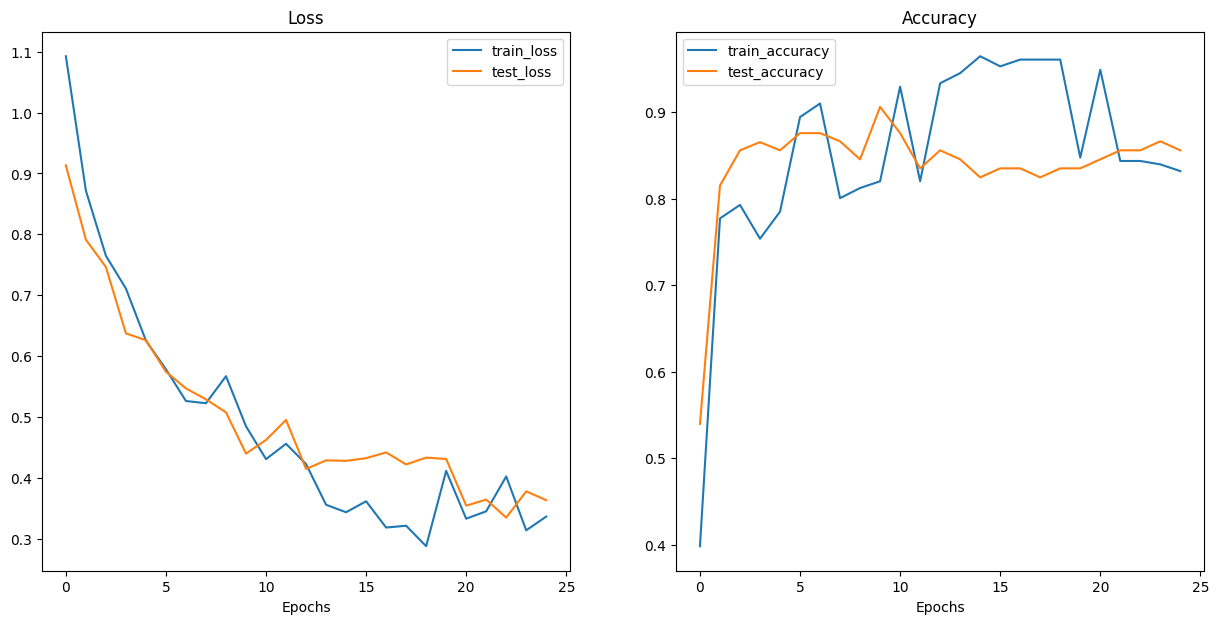

In [12]:
from going_modular.helper_functions import plot_loss_curves

plot_loss_curves(results=results)

Wow! This does a lot better than out previous models

Let's save our modell, and then visualize some of these predictions

## Save Model

In [13]:
from going_modular import utils

utils.save_model(model=model, target_dir="models", model_name="pretrained_effnet_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models\pretrained_effnet_feature_extractor_pizza_steak_sushi.pth


## Visualizing Predictions

In [72]:
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: list[str],
                        transform: torchvision.transforms,
                        device: torch.device=device):
    
    image = Image.open(image_path)

    model.to(device)
    model.eval()

    with torch.inference_mode():
        transformed_image = transform(image).unsqueeze(dim=0)
        predictions = model(transformed_image.to(device))

    predictions_probability = torch.softmax(predictions, dim=1)
    highest_likely_class = torch.argmax(predictions_probability, dim=1)

    max_probability_percentage = predictions_probability.max() * 100

    plt.figure()
    plt.imshow(image)
    plt.title(f"Prediction: {class_names[highest_likely_class]} | Probability: {max_probability_percentage:.2f}%")
    plt.axis(False)

Let's grab random images from the test data to see it out

You can even re-run this cell multiple times to see how the model classifies different images

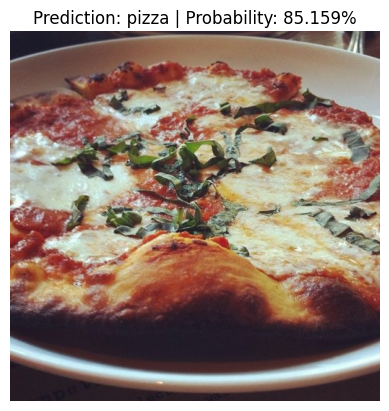

In [73]:
import random

# get list all image paths from test data 
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))

# get 1 sample from list
sample = random.choice(test_image_path_list)

pred_and_plot_image(model=model, image_path=sample, class_names=class_names, transform=auto_transforms, device=device)